# Skapa 2 modeller per ticker   
1. En modell som använder tomorrows close som target  
2. En modell som använder after tomorrows close som target   

In [123]:
from xgboost import XGBClassifier
from pytrends.request import TrendReq
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
import ta
import pickle
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
plt.style.use('fivethirtyeight')
pd.set_option('display.width', 200)
import streamlit as st


In [124]:
# print pandas version
print('pandas version: {}'.format(pd.__version__))
# print numpy version
print('numpy version: {}'.format(np.__version__))
# print matplotlib version
print('matplotlib version: {}'.format(plt.matplotlib.__version__))
# print yfinance version
print('yfinance version: {}'.format(yf.__version__))
# print pickle version
print('pickle version: {}'.format(pickle.format_version))

import ta
# print ta version
# print('ta version: {}'.format(ta.__version__))
# '0.10.2'
# print streamlit version
print('streamlit version: {}'.format(st.__version__))

import xgboost
print('xgboost version: {}'.format(xgboost.__version__))



pandas version: 1.4.3
numpy version: 1.22.3
matplotlib version: 3.5.2
yfinance version: 0.1.72
pickle version: 4.0
streamlit version: 1.10.0
xgboost version: 1.6.1


In [125]:
tickers = ['BTC-USD','ETH-USD','BCH-USD','ZRX-USD','XRP-USD']
ticker_names = ['Bitcoin','Ethereum','Bitcoin Cash','0X','Ripple']

In [126]:
# fill up a dataframe with all dates from 2015 up to today
def get_all_dates():
    start_date = dt(2005, 1, 1)
    end_date = dt.today()
    dates = pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    return df


## get Google Trends Bitcoin data


Bitcoin
Ethereum
Bitcoin Cash
0X
Ripple


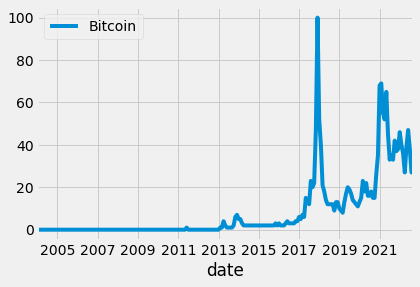

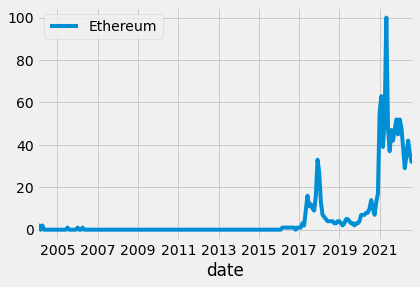

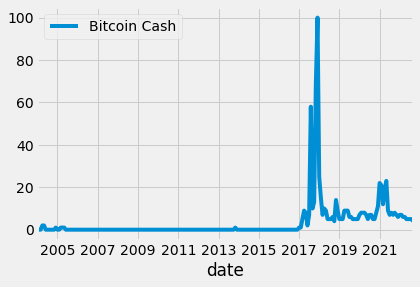

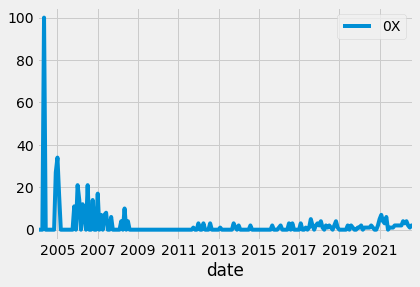

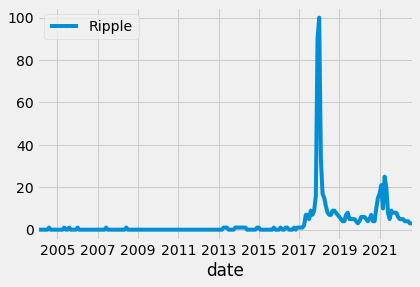

In [127]:
# get google trends data
from pytrends.request import TrendReq

pytrends = TrendReq()
df_trend = get_all_dates()
for ticker_name in ticker_names:
    print(ticker_name)
    pytrends.build_payload(kw_list=[ticker_name], cat=7, timeframe='all')
    df_temp = pytrends.interest_over_time()
    df_temp = df_temp.drop(columns=['isPartial'])
    df_temp.plot()
    df_trend = df_trend.merge(df_temp, how='left', left_index=True, right_index=True)
    df_trend[ticker_name] = df_trend[ticker_name].fillna(method='ffill')/30
    df_trend[ticker_name+'_30'] = df_trend[ticker_name].rolling(30, 1).mean()
    df_trend[ticker_name+'_90'] = df_trend[ticker_name].rolling(90, 1).mean()
    df_trend[ticker_name+'_250'] = df_trend[ticker_name].rolling(250, 1).mean()
    
df_trend = df_trend[ticker_names + [ticker_name+'_30' for ticker_name in ticker_names] + [ticker_name+'_90' for ticker_name in ticker_names] + [ticker_name+'_250' for ticker_name in ticker_names]]


In [128]:
df_trend.to_csv('google_trends.csv')
df_trend.tail()


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_30,Ethereum_30,Bitcoin Cash_30,0X_30,Ripple_30,Bitcoin_90,Ethereum_90,Bitcoin Cash_90,0X_90,Ripple_90,Bitcoin_250,Ethereum_250,Bitcoin Cash_250,0X_250,Ripple_250
2022-09-28,0.9,1.0667,0.1333,0.0667,0.1,0.9,1.0667,0.1356,0.0667,0.1,1.0263,1.1126,0.1563,0.0552,0.1,1.1861,1.2389,0.1812,0.0831,0.1305
2022-09-29,0.9,1.0667,0.1333,0.0667,0.1,0.9,1.0667,0.1344,0.0667,0.1,1.0222,1.1111,0.1559,0.0556,0.1,1.1836,1.2363,0.1808,0.0831,0.1303
2022-09-30,0.9,1.0667,0.1333,0.0667,0.1,0.9,1.0667,0.1333,0.0667,0.1,1.0181,1.1096,0.1556,0.0559,0.1,1.1811,1.2336,0.1804,0.0831,0.1300
2022-10-01,0.9,1.0667,0.1333,0.0667,0.1,0.9,1.0667,0.1333,0.0667,0.1,1.0141,1.1081,0.1552,0.0563,0.1,1.1785,1.2309,0.1800,0.0831,0.1297
2022-10-02,0.9,1.0667,0.1333,0.0667,0.1,0.9,1.0667,0.1333,0.0667,0.1,1.0100,1.1067,0.1548,0.0567,0.1,1.1760,1.2283,0.1796,0.0831,0.1295


## skapa alla modellerna

In [129]:
df_trend.query('index>"2017-01-01"').head(35)

,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_30,Ethereum_30,Bitcoin Cash_30,0X_30,Ripple_30,Bitcoin_90,Ethereum_90,Bitcoin Cash_90,0X_90,Ripple_90,Bitcoin_250,Ethereum_250,Bitcoin Cash_250,0X_250,Ripple_250
2017-01-02,0.2000,0.0333,0.0333,0.0,0.0333,0.1378,0.0333,0.0022,0.0000,0.0333,0.1248,0.0222,0.0007,0.0000,0.0222,0.1125,0.0293,0.0003,0.0244,0.0167
2017-01-03,0.2000,0.0333,0.0333,0.0,0.0333,0.1400,0.0333,0.0033,0.0000,0.0333,0.1259,0.0222,0.0011,0.0000,0.0222,0.1131,0.0293,0.0004,0.0244,0.0168
2017-01-04,0.2000,0.0333,0.0333,0.0,0.0333,0.1422,0.0333,0.0044,0.0000,0.0333,0.1270,0.0222,0.0015,0.0000,0.0222,0.1136,0.0293,0.0005,0.0244,0.0169
2017-01-05,0.2000,0.0333,0.0333,0.0,0.0333,0.1444,0.0333,0.0056,0.0000,0.0333,0.1281,0.0222,0.0019,0.0000,0.0222,0.1141,0.0293,0.0007,0.0244,0.0171
2017-01-06,0.2000,0.0333,0.0333,0.0,0.0333,0.1467,0.0333,0.0067,0.0000,0.0333,0.1293,0.0222,0.0022,0.0000,0.0222,0.1145,0.0293,0.0008,0.0244,0.0171
2017-01-07,0.2000,0.0333,0.0333,0.0,0.0333,0.1489,0.0333,0.0078,0.0000,0.0333,0.1304,0.0222,0.0026,0.0000,0.0222,0.1149,0.0293,0.0009,0.0244,0.0171
2017-01-08,0.2000,0.0333,0.0333,0.0,0.0333,0.1511,0.0333,0.0089,0.0000,0.0333,0.1315,0.0222,0.0030,0.0000,0.0222,0.1153,0.0293,0.0011,0.0244,0.0171
2017-01-09,0.2000,0.0333,0.0333,0.0,0.0333,0.1533,0.0333,0.0100,0.0000,0.0333,0.1326,0.0222,0.0033,0.0000,0.0222,0.1157,0.0293,0.0012,0.0244,0.0171
2017-01-10,0.2000,0.0333,0.0333,0.0,0.0333,0.1556,0.0333,0.0111,0.0000,0.0333,0.1337,0.0222,0.0037,0.0000,0.0222,0.1161,0.0293,0.0013,0.0244,0.0171
2017-01-11,0.2000,0.0333,0.0333,0.0,0.0333,0.1578,0.0333,0.0122,0.0000,0.0333,0.1348,0.0222,0.0041,0.0000,0.0222,0.1165,0.0293,0.0015,0.0244,0.0171


In [141]:
def get_all(tickers):
    df = pd.DataFrame()
    for ticker in tickers:
        all_tickers = yf.download(ticker)
        df[ticker] = yf.download(ticker, period='max')['Close']
        
    df.index = pd.to_datetime(df.index)
    return df

In [142]:
df_org= get_all(tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [143]:
display(df_org.isna().sum())
df_org.shape

BTC-USD       0
ETH-USD    1149
BCH-USD    1149
ZRX-USD    1081
XRP-USD    1149
dtype: int64

(2938, 5)

In [144]:

def fit_predict(train, test, target, predictors, model, proba_val=None):
    model.fit(train[predictors], train[target])

    if proba_val:  # använd proba
        preds = model.predict_proba(test[predictors])[:, 1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)

    return combined



In [145]:
def backtest(data, target, model, predictors, proba_val=0.6, start=360, step=180):
    """"
    Args:
        data (DataFrame): Data to use for backtesting
        model: Tex RandomForestClassifier
        predictors: Features in data to use for backtesting
        proba_val (float): threshold för att få 1 annars 0 i predictions.
        start (int, optional): Hur många rader in i data skall vi starta testet. Defaults to 180.
        step (int, optional): Hur många rader skall vi ta i varje batch framåt. Defaults to 60.

    Returns:
        DataFrame: Två kolumner med true_y och prediktioner 
    """
    all_predictions = []
    print('last date', data.iloc[-1].name)
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = fit_predict(train, test, target, predictors, model, proba_val=proba_val)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)


def print_results(predictions, target):
    prec = precision_score(predictions[target], predictions["Predictions"])
    print(f'Fördelning av {target}: 1 vs 0:')
    print(predictions[target].value_counts() / predictions.shape[0])

    predictions.Predictions = predictions.Predictions.astype(int)
    print(predictions.value_counts())
    print(f"Precision:\t{prec:.4f}")
    return prec


### Beräkna predictors

In [146]:
def new_features(df_, ticker, target):
    df = df_.copy()
    # tidsintervall i dagar för rullande medelvärden
    # skulle helst ha med upp till 4 år men ETH har för få värden
    horizons = [2, 5, 60, 250]
    new_predictors = []
    df['stoch_k'] = ta.momentum.stochrsi_k(df[ticker], window=10)

    # Target
    # tomorrow's close price - alltså nästa dag
    df['Tomorrow'] = df[ticker].shift(-1)
    # after tomorrow's close price - alltså om två dagar
    df['After_tomorrow'] = df[ticker].shift(-2)
    df['y1'] = (df['Tomorrow'] > df[ticker]).astype(int)
    df['y2'] = (df['After_tomorrow'] > df[ticker]).astype(int)
    # df.dropna(inplace=True)

    for horizon in horizons:
        rolling_averages = df.rolling(horizon, 1).mean()

        ratio_column = f"Close_Ratio_{horizon}"
        df[ratio_column] = df[ticker] / rolling_averages[ticker]

        trend_column = f"Trend_{horizon}"
        df[trend_column] = df.shift(1).rolling(horizon, 1).sum()[target]

        new_predictors += [ratio_column, trend_column]

    new_predictors.append('stoch_k')
    # df = df.dropna()
    return df, new_predictors


In [147]:
pd.options.display.max_columns = 200    # default 20
pd.options.display.max_colwidth = 60  # default 50
pd.options.display.precision = 4      # default 6
print(tickers[0])
df, new_predictors = new_features(df_org, tickers[0], 'y1')
df[new_predictors+['y1']]


BTC-USD


,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,stoch_k,y1
Date,,,,,,,,,,
2014-09-17,1.0000,NaN,1.0000,NaN,1.0000,NaN,1.0000,NaN,NaN,0
2014-09-18,0.9627,0.0,0.9627,0.0,0.9627,0.0,0.9627,0.0,NaN,0
2014-09-19,0.9638,0.0,0.9278,0.0,0.9278,0.0,0.9278,0.0,NaN,1
2014-09-20,1.0176,1.0,0.9704,1.0,0.9704,1.0,0.9704,1.0,NaN,0
2014-09-21,0.9875,1.0,0.9567,1.0,0.9567,1.0,0.9567,1.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...
2022-09-28,1.0082,1.0,1.0171,2.0,0.9165,27.0,0.6318,121.0,0.9296,1
2022-09-29,1.0038,2.0,1.0180,3.0,0.9261,28.0,0.6378,122.0,0.9633,0
2022-09-30,0.9964,1.0,1.0041,3.0,0.9223,28.0,0.6346,121.0,0.9591,0


### Vi använder XGBoost

In [148]:
xgb_params = {'gamma': 0.7, 'learning_rate': 0.005, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.4}
from xgboost import XGBClassifier
xgb = XGBClassifier(**xgb_params, random_state=2022, n_jobs=-1)

predictions_xgb = backtest(df, 'y1', xgb, new_predictors, proba_val= 0.6, step=30)
xgb_try = print_results(predictions_xgb,'y1')

pd.DataFrame(xgb.feature_importances_,columns=['importance'], index=new_predictors).sort_values(by='importance', ascending=False)

last date 2022-10-02 00:00:00
Fördelning av y1: 1 vs 0:
1    0.5419
0    0.4581
Name: y1, dtype: float64
y1  Predictions
1   0              1310
0   0              1112
1   1                87
0   1                69
dtype: int64
Precision:	0.5577


,importance
Trend_60,0.1149
Close_Ratio_250,0.1143
Close_Ratio_2,0.1131
stoch_k,0.1123
Close_Ratio_60,0.1120
Close_Ratio_5,0.1099
Trend_5,0.1091
Trend_2,0.1086
Trend_250,0.1058


In [149]:
df

,BTC-USD,ETH-USD,BCH-USD,ZRX-USD,XRP-USD,stoch_k,Tomorrow,After_tomorrow,y1,y2,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250
Date,,,,,,,,,,,,,,,,,,
2014-09-17,457.3340,NaN,NaN,NaN,NaN,NaN,424.4400,394.7960,0,0,1.0000,NaN,1.0000,NaN,1.0000,NaN,1.0000,NaN
2014-09-18,424.4400,NaN,NaN,NaN,NaN,NaN,394.7960,408.9040,0,0,0.9627,0.0,0.9627,0.0,0.9627,0.0,0.9627,0.0
2014-09-19,394.7960,NaN,NaN,NaN,NaN,NaN,408.9040,398.8210,1,1,0.9638,0.0,0.9278,0.0,0.9278,0.0,0.9278,0.0
2014-09-20,408.9040,NaN,NaN,NaN,NaN,NaN,398.8210,402.1520,0,0,1.0176,1.0,0.9704,1.0,0.9704,1.0,0.9704,1.0
2014-09-21,398.8210,NaN,NaN,NaN,NaN,NaN,402.1520,435.7910,1,1,0.9875,1.0,0.9567,1.0,0.9567,1.0,0.9567,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-28,19426.7207,1337.4109,114.2623,0.2673,0.4507,0.9296,19573.0508,19431.7891,1,1,1.0082,1.0,1.0171,2.0,0.9165,27.0,0.6318,121.0
2022-09-29,19573.0508,1335.6523,116.7401,0.2700,0.4854,0.9633,19431.7891,19312.0957,0,0,1.0038,2.0,1.0180,3.0,0.9261,28.0,0.6378,122.0
2022-09-30,19431.7891,1327.9786,120.0403,0.2673,0.4798,0.9591,19312.0957,19219.0762,0,0,0.9964,1.0,1.0041,3.0,0.9223,28.0,0.6346,121.0


Loop öve all tickers och skapa 2 modeller  
    En mot y1 och en mot y2  
    spara båda modellerna  
Totalt 2 modeller per ticker (= 10 st)    

Modellens namn:  
    ticker[:3]_y1  
    ticker[:3]_y2

In [156]:
def add_google_trends(df_, df_trend, ticker, new_predictors):
    df = df_.copy()
    
    lookup = {'BTC-USD': 'Bitcoin', 'ETH-USD': 'Ethereum', 'BCH-USD': 'Bitcoin Cash', 'XRP-USD': 'Ripple', 'ZRX-USD': '0X'}
    ticker_namn = lookup[ticker]
    
    df[ticker_namn + '_goog30'] = df_trend[ticker_namn + '_30']
    new_predictors.append(ticker_namn + '_goog30')
    df[ticker_namn + '_goog90'] = df_trend[ticker_namn + '_90']
    new_predictors.append(ticker_namn + '_goog90')
    df[ticker_namn + '_goog250'] = df_trend[ticker_namn + '_250']
    new_predictors.append(ticker_namn + '_goog250')
    
    return df, new_predictors

xgb_params = {'gamma': 0.7, 'learning_rate': 0.005, 'max_depth': 7,
                  'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.4}
for enum, ticker in enumerate(tickers):
    namn = ticker[:3]
    print(namn)
    target = 'y1'
    xgb = XGBClassifier(**xgb_params,  random_state=2022, n_jobs=-1)
    df, new_predictors = new_features(df_org, ticker, target)
    df, new_predictors = add_google_trends(df, df_trend, ticker, new_predictors)
    predictions_xgb = backtest(df, target, xgb, new_predictors, proba_val= 0.55, step=30)
    xgb_try = print_results(predictions_xgb, target)
    display(pd.DataFrame(xgb.feature_importances_,columns=['importance'], index=new_predictors).sort_values(by='importance', ascending=False))
    
    test_index = int(df.shape[0] * 0.8)
    train = df.iloc[:test_index].copy()
    test = df.iloc[test_index:].copy()
    xgb = XGBClassifier(early_stopping_rounds=100, 
                        **xgb_params,  
                        random_state=2022, n_jobs=-1)
    xgb.fit(train[new_predictors], train[target], 
            eval_set=[(train[new_predictors], train[target]),
                      (test[new_predictors], test[target])],
            verbose=False)
    
    # pickle.dump(xgb, open(f'{namn}_y1.pkl', 'wb'))
    xgb.save_model(f'{namn}_{target}.json')
    
    
    target='y2'
    xgb = XGBClassifier(**xgb_params,  random_state=2022, n_jobs=-1)
    df, new_predictors = new_features(df_org, ticker, target)
    df, new_predictors = add_google_trends(df, df_trend, ticker, new_predictors)
    predictions_xgb = backtest(df, target, xgb, new_predictors, proba_val=0.55, step=30)
    xgb_try = print_results(predictions_xgb, target)
    display(pd.DataFrame(xgb.feature_importances_,columns=['importance'], index=new_predictors).sort_values(by='importance', ascending=False))

    test_index = int(df.shape[0] * 0.8)
    train = df.iloc[:test_index].copy()
    test = df.iloc[test_index:].copy()
    xgb = XGBClassifier(early_stopping_rounds=100, 
                        **xgb_params,  
                        random_state=2022, n_jobs=-1)
    xgb.fit(train[new_predictors], train[target],
            eval_set=[(train[new_predictors], train[target]),
                      (test[new_predictors], test[target])],
            verbose=False)

    # pickle dump model
    # pickle.dump(xgb, open(f'{namn}_y2.pkl', 'wb'))
    xgb.save_model(f'{namn}_{target}.json')

    

BTC
last date 2022-10-02 00:00:00
Fördelning av y1: 1 vs 0:
1    0.5419
0    0.4581
Name: y1, dtype: float64
y1  Predictions
1   0              929
0   0              805
1   1              468
0   1              376
dtype: int64
Precision:	0.5545


,importance
Bitcoin_goog250,0.0910
Trend_60,0.0857
Trend_5,0.0846
Close_Ratio_250,0.0845
Bitcoin_goog90,0.0842
Close_Ratio_2,0.0840
stoch_k,0.0828
Close_Ratio_5,0.0819
Bitcoin_goog30,0.0818
Close_Ratio_60,0.0816


last date 2022-10-02 00:00:00
Fördelning av y2: 1 vs 0:
1    0.5539
0    0.4461
Name: y2, dtype: float64
y2  Predictions
1   1              776
0   0              745
1   0              652
0   1              405
dtype: int64
Precision:	0.6571


,importance
Trend_2,0.2284
Close_Ratio_5,0.0918
Close_Ratio_2,0.0900
Trend_5,0.0729
Trend_60,0.0692
Bitcoin_goog250,0.0676
stoch_k,0.0663
Close_Ratio_60,0.0660
Bitcoin_goog90,0.0645
Trend_250,0.0621


ETH
last date 2022-10-02 00:00:00
Fördelning av y1: 1 vs 0:
0    0.6435
1    0.3565
Name: y1, dtype: float64
y1  Predictions
0   0              1460
1   0               680
    1               239
0   1               199
dtype: int64
Precision:	0.5457


,importance
Close_Ratio_60,0.2185
Close_Ratio_250,0.1581
Close_Ratio_5,0.1559
Trend_60,0.1027
Close_Ratio_2,0.0859
stoch_k,0.0448
Ethereum_goog30,0.0416
Ethereum_goog90,0.0403
Trend_250,0.0397
Ethereum_goog250,0.0393


last date 2022-10-02 00:00:00
Fördelning av y2: 1 vs 0:
0    0.6431
1    0.3569
Name: y2, dtype: float64
y2  Predictions
0   0              1466
1   0               598
    1               322
0   1               192
dtype: int64
Precision:	0.6265


,importance
Close_Ratio_250,0.2258
Close_Ratio_5,0.1340
Close_Ratio_60,0.1323
Trend_5,0.1034
Trend_2,0.0950
Close_Ratio_2,0.0944
Trend_60,0.0476
Ethereum_goog250,0.0353
Trend_250,0.0335
Ethereum_goog90,0.0334


BCH
last date 2022-10-02 00:00:00
Fördelning av y1: 1 vs 0:
0    0.6645
1    0.3355
Name: y1, dtype: float64
y1  Predictions
0   0              1598
1   0               743
    1               122
0   1               115
dtype: int64
Precision:	0.5148


,importance
Close_Ratio_60,0.2519
Close_Ratio_250,0.1575
Close_Ratio_5,0.0899
Trend_60,0.0864
Close_Ratio_2,0.0848
stoch_k,0.0605
Trend_5,0.0503
Trend_250,0.0464
Bitcoin Cash_goog90,0.0437
Bitcoin Cash_goog30,0.0435


last date 2022-10-02 00:00:00
Fördelning av y2: 1 vs 0:
0    0.6699
1    0.3301
Name: y2, dtype: float64
y2  Predictions
0   0              1589
1   0               596
    1               255
0   1               138
dtype: int64
Precision:	0.6489


,importance
Close_Ratio_60,0.2330
Close_Ratio_250,0.1998
Trend_2,0.1037
Close_Ratio_5,0.0983
Close_Ratio_2,0.0782
Trend_60,0.0519
stoch_k,0.0498
Bitcoin Cash_goog30,0.0382
Bitcoin Cash_goog250,0.0381
Trend_250,0.0377


ZRX
last date 2022-10-02 00:00:00
Fördelning av y1: 1 vs 0:
0    0.6478
1    0.3522
Name: y1, dtype: float64
y1  Predictions
0   0              1552
1   0               782
    1               126
0   1               118
dtype: int64
Precision:	0.5164


,importance
Close_Ratio_250,0.1931
Close_Ratio_2,0.1668
Close_Ratio_5,0.1422
Close_Ratio_60,0.1376
Trend_60,0.0540
Trend_250,0.0513
0X_goog30,0.0445
0X_goog250,0.0445
Trend_5,0.0433
stoch_k,0.0426


last date 2022-10-02 00:00:00
Fördelning av y2: 1 vs 0:
0    0.6548
1    0.3452
Name: y2, dtype: float64
y2  Predictions
0   0              1515
1   0               663
    1               227
0   1               173
dtype: int64
Precision:	0.5675


,importance
Close_Ratio_5,0.1846
Close_Ratio_250,0.1764
Close_Ratio_2,0.1098
Trend_2,0.1013
Close_Ratio_60,0.0987
Trend_5,0.0563
Trend_60,0.0526
Trend_250,0.0461
stoch_k,0.0449
0X_goog90,0.0441


XRP
last date 2022-10-02 00:00:00
Fördelning av y1: 1 vs 0:
0    0.6598
1    0.3402
Name: y1, dtype: float64
y1  Predictions
0   0              1591
1   0               735
    1               142
0   1               110
dtype: int64
Precision:	0.5635


,importance
Close_Ratio_250,0.2245
Close_Ratio_2,0.1610
Trend_60,0.1331
Close_Ratio_5,0.1203
Close_Ratio_60,0.0804
stoch_k,0.0447
Ripple_goog250,0.0422
Ripple_goog90,0.0404
Trend_250,0.0387
Trend_2,0.0386


last date 2022-10-02 00:00:00
Fördelning av y2: 1 vs 0:
0    0.6718
1    0.3282
Name: y2, dtype: float64
y2  Predictions
0   0              1623
1   0               671
    1               175
0   1               109
dtype: int64
Precision:	0.6162


,importance
Close_Ratio_250,0.2518
Close_Ratio_2,0.1261
Trend_2,0.1005
Close_Ratio_5,0.0983
Trend_60,0.0873
Close_Ratio_60,0.0691
stoch_k,0.0638
Trend_5,0.0498
Ripple_goog90,0.0406
Ripple_goog250,0.0379


In [157]:
ticker='BTC-USD'
namn = ticker[:3]
print(namn)

# display(df_org)
df, new_predictors = new_features(df_org, ticker, 'y1')
df, new_predictors = add_google_trends(df, df_trend, ticker, new_predictors)
# preddar = backtest(df, 'y1', xgb, new_predictors, proba_val=0.55, step=30)
# print_results(preddar, 'y1')
# display(pd.DataFrame(xgb.feature_importances_, columns=[
#     'importance'], index=new_predictors).sort_values(by='importance', ascending=False))


BTC


In [158]:
loaded_model = XGBClassifier()
ticker='BTC-USD'
name=ticker[:3]
loaded_model.load_model(name+'_y1.json')
loaded_model.best_ntree_limit
# preddar = backtest(df, 'y1', loaded_model, new_predictors, proba_val=0.55, step=30)
# print_results(preddar, 'y1')


64